In [1]:
from pathlib import Path
import numpy as np
from gnpy.tools.json_io import load_equipment, load_network
from gnpy.core.info import create_arbitrary_spectral_information
from gnpy.core.utils import dbm2watt, watt2dbm, lin2db
from gnpy.core.elements import Transceiver, Fiber, Edfa
import matplotlib.pyplot as plt


	WARNING missing type_variety attribute in eqpt_config.json[Roadm]
	default value is type_variety = default




Número de canales: 77, Potencia total Tx: 0.86 dBm → Potencia por canal: -18.00 dBm


     Etapa | Pot[dBm] |  OSNR_bw | OSNR@0.1nm |    OSNR_clásico
---------------------------------------------------------------
    Site_A |   -18.00 |    40.00 |      44.08 |                  
     Edfa1 |     5.00 |    30.38 |      34.46 |                  
     Span1 |   -25.00 |    30.38 |      34.46 |                  
     Edfa2 |    -2.00 |    23.02 |      27.10 |                  
     Span2 |   -18.00 |    23.02 |      27.10 |                  
     Edfa3 |     5.00 |    22.37 |      26.45 |                  
     Span3 |   -32.00 |    22.37 |      26.45 |                  
     Edfa4 |    -9.00 |    15.90 |      19.99 |                  
    Site_B |    -9.00 |    22.37 |      26.45 |            19.931

Advertencia: La potencia de la señal recibida (-9.00 dBm) es menor que la sensibilidad del receptor (-8.00 dBm).


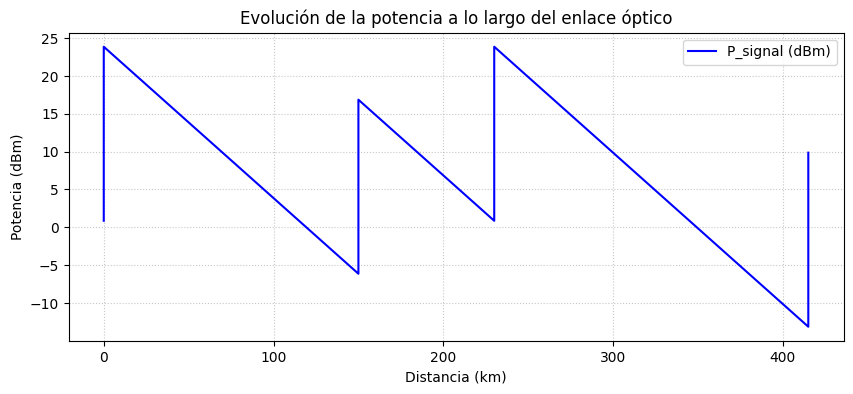

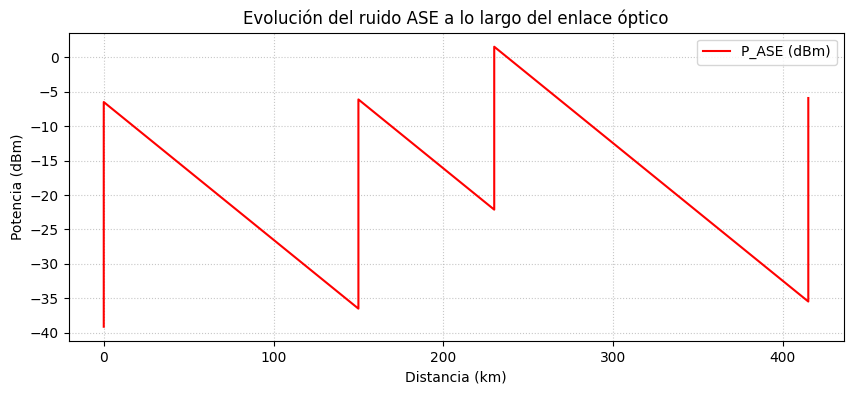

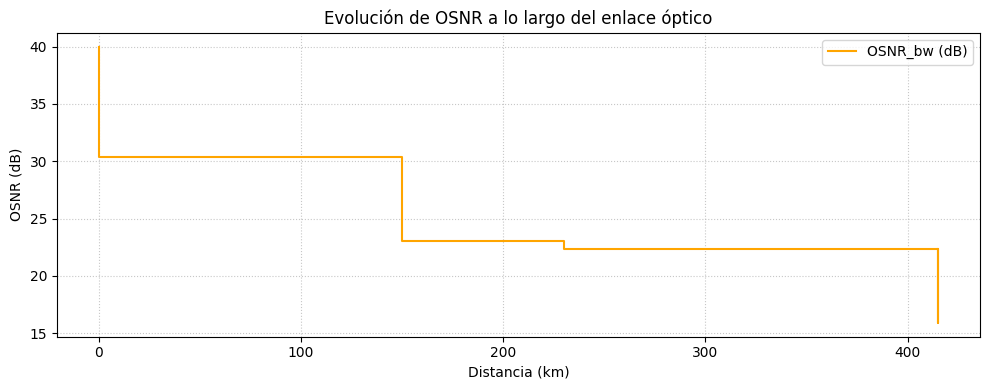

In [10]:
# 1) PARÁMETROS
f_min, f_max = 191.3e12, 195.1e12
spacing = 50e9
roll_off = 0.15
tx_osnr = 40
baud_rate = 32e9
B_n = 12.5e9
nch = int(np.floor((f_max - f_min) / spacing)) + 1

# 2) Entradas usuario
sens = float(input("Introduce la sensibilidad del receptor en dBm: "))
P_tot_dbm_input = float(input("Introduce la potencia total del transmisor en dBm: "))
nf1 = float(input("Introduce NF para EDFA1 en dB(Para cálculos manuales ) : "))
nf2 = float(input("Introduce NF para EDFA2 en dB(Para cálculos manuales ): "))
nf3 = float(input("Introduce NF para EDFA3 en dB(Para cálculos manuales ): "))
nf4=  float(input("Introduce NF para EDFA4 en dB(Para cálculos manuales ): "))

tx_power_dbm = P_tot_dbm_input - 10 * np.log10(nch)
print(f"\nNúmero de canales: {nch}, Potencia total Tx: {P_tot_dbm_input:.2f} dBm → Potencia por canal: {tx_power_dbm:.2f} dBm\n")

# 3) Helpers OSNR
def get_avg_osnr_db(si):
    sig = np.array([np.sum(ch.power) for ch in si.carriers])
    noise = si.ase + si.nli
    return float(np.mean(lin2db(np.where(noise > 0, sig / noise, np.inf))))

def get_avg_osnr_01nm_db(si):
    return get_avg_osnr_db(si) + 10 * np.log10(si.baud_rate[0] / B_n)

def format_osnr(v, decimals=2):
    return "∞" if np.isinf(v) else f"{v:.{decimals}f}"

def classical_osnr_parallel(signal_power_dbm, ase_noise_dbm):
    if ase_noise_dbm <= -190:
        return float('inf')
    signal_power_lin = dbm2watt(signal_power_dbm)
    ase_noise_lin = dbm2watt(ase_noise_dbm)
    if ase_noise_lin <= 0:
        return float('inf')
    return lin2db(signal_power_lin / ase_noise_lin)
# 4) SpectralInformation inicial
freq = [f_min + spacing * i for i in range(nch)]
signal = [dbm2watt(tx_power_dbm)] * nch
delta = np.zeros(nch)
label = [f"{baud_rate * 1e-9:.2f}G"] * nch

si = create_arbitrary_spectral_information(
    freq, slot_width=spacing, signal=signal,
    baud_rate=baud_rate, roll_off=roll_off,
    delta_pdb_per_channel=delta,
    tx_osnr=tx_osnr, tx_power=tx_power_dbm, label=label
)
si.signal = si.signal.astype(np.float64)
si.nli = si.nli.astype(np.float64)

lin_osnr0 = 10**(tx_osnr / 10)
si.ase = np.array([np.sum(ch.power) / lin_osnr0 for ch in si.carriers], dtype=np.float64)

# 5) Cargar red y nodos
equipment = load_equipment(Path("eqpt_final.json"))
network = load_network(Path("enlace_WDM.json"), equipment)
tx = next(n for n in network.nodes if isinstance(n, Transceiver) and n.uid == "Site_A")
rx = next(n for n in network.nodes if isinstance(n, Transceiver) and n.uid == "Site_B")
edfas = sorted([n for n in network.nodes if isinstance(n, Edfa)], key=lambda x: x.uid)
fibs = sorted([n for n in network.nodes if isinstance(n, Fiber)], key=lambda x: x.uid)
edfa1, edfa2, edfa3, edfa4 = edfas
span1, span2 , span3 = fibs[0], fibs[1], fibs[2]

# 6) Gráficas: estructuras de datos
plot_data = {'distance': [], 'signal_power': [], 'ase_power': [], 'osnr_bw': []}
current_distance = 0

def add_plot_point(dist, si_current, osnr_val):
    plot_data['distance'].append(dist)
    plot_data['signal_power'].append(watt2dbm(sum(ch.power[0] for ch in si_current.carriers)))
    plot_data['ase_power'].append(watt2dbm(sum(si_current.ase)))
    plot_data['osnr_bw'].append(osnr_val)

# 7) Cabecera de tabla
header = f"{'Etapa':>10s} | {'Pot[dBm]':>8s} | {'OSNR_bw':>8s} | {'OSNR@0.1nm':>10s} | {'OSNR_clásico':>15s}"
print("\n" + header)
print("-" * len(header))

# 8) Función print_stage corregida: OSNR teórico usa potencia por canal
def print_stage(name, p_dbm, osnr_db, osnr_01nm, current_total_ase_lin_for_parallel_calc=None):
    pch_dbm = p_dbm - 10 * np.log10(nch)
    p_dbm_str = f"{pch_dbm:.2f}" 
    osnr_db_formatted = f"{osnr_db:.2f}"

    class_osnr_parallel_val = '               '
    if name == "Site_B":
        if current_total_ase_lin_for_parallel_calc is not None and current_total_ase_lin_for_parallel_calc > 0:
            # 💡 Aquí se usa potencia por canal
            pch_dbm = p_dbm - 10 * np.log10(nch)
            class_osnr_parallel_val = format_osnr(
                classical_osnr_parallel(pch_dbm, watt2dbm(current_total_ase_lin_for_parallel_calc)), 3
            )
        elif current_total_ase_lin_for_parallel_calc == 0:
            class_osnr_parallel_val = "∞"

    print(f"{name:>10s} | {p_dbm_str:>8s} | {osnr_db_formatted:>8s} | {format_osnr(osnr_01nm):>10s} | {class_osnr_parallel_val:>17s}")
# Site_A
p0 = P_tot_dbm_input
o0 = tx_osnr
o0_1 = o0 + 10 * np.log10(baud_rate / B_n)
current_total_ase_lin_for_parallel_calc = dbm2watt(-150.0)  # ruido casi nulo
print_stage(tx.uid, p0, o0, o0_1, current_total_ase_lin_for_parallel_calc)
add_plot_point(current_distance, si, o0)

# EDFA1
si = edfa1(si)
p1 = watt2dbm(sum(ch.power[0] for ch in si.carriers))
o1 = get_avg_osnr_db(si)
o1_1 = get_avg_osnr_01nm_db(si)
gain1_db = edfa1.operational.gain_target
QUANTUM_NOISE_FLOOR_DBM = -58.0
p_ase1 = dbm2watt(QUANTUM_NOISE_FLOOR_DBM + nf1 + gain1_db)
current_total_ase_lin_for_parallel_calc = (current_total_ase_lin_for_parallel_calc * 10**(gain1_db / 10)) + p_ase1
print_stage(edfa1.uid, p1, o1, o1_1, current_total_ase_lin_for_parallel_calc)
add_plot_point(current_distance, si, o1)

# Span1
ase_before = si.ase.copy()
nli_before = si.nli.copy()
p_in = watt2dbm(sum(ch.power[0] for ch in si.carriers))
ase_in_lin = current_total_ase_lin_for_parallel_calc
span1.ref_pch_in_dbm = p_in - 10 * np.log10(nch)
si = span1(si)
loss1_dB = span1.params.loss_coef * span1.params.length + span1.params.con_in + span1.params.con_out + span1.params.att_in
loss1_lin = 10**(-loss1_dB / 10)
si.ase = ase_before * loss1_lin
si.nli = nli_before * loss1_lin
current_total_ase_lin_for_parallel_calc = ase_in_lin * loss1_lin
p_s1 = watt2dbm(sum(ch.power[0] for ch in si.carriers))
o_s1 = get_avg_osnr_db(si)
o_s1_1 = get_avg_osnr_01nm_db(si)
current_distance += span1.params.length / 1000
print_stage(span1.uid, p_s1, o_s1, o_s1_1, current_total_ase_lin_for_parallel_calc)
add_plot_point(current_distance, si, o_s1)

# EDFA2
si = edfa2(si)
p2 = watt2dbm(sum(ch.power[0] for ch in si.carriers))
o2 = get_avg_osnr_db(si)
o2_1 = get_avg_osnr_01nm_db(si)
gain2_db = edfa2.operational.gain_target
p_ase2 = dbm2watt(QUANTUM_NOISE_FLOOR_DBM + nf2 + gain2_db)
current_total_ase_lin_for_parallel_calc = (current_total_ase_lin_for_parallel_calc * 10**(gain2_db / 10)) + p_ase2
print_stage(edfa2.uid, p2, o2, o2_1, current_total_ase_lin_for_parallel_calc)
add_plot_point(current_distance, si, o2)

# Span2
ase_before = si.ase.copy()
nli_before = si.nli.copy()
p_in = watt2dbm(sum(ch.power[0] for ch in si.carriers))
ase_in_lin = current_total_ase_lin_for_parallel_calc
span2.ref_pch_in_dbm = p_in - 10 * np.log10(nch)
si = span2(si)
loss2_dB = span2.params.loss_coef * span2.params.length + span2.params.con_in + span2.params.con_out + span2.params.att_in
loss2_lin = 10**(-loss2_dB / 10)
si.ase = ase_before * loss2_lin
si.nli = nli_before * loss2_lin
current_total_ase_lin_for_parallel_calc = ase_in_lin * loss2_lin
p_s2 = watt2dbm(sum(ch.power[0] for ch in si.carriers))
o_s2 = get_avg_osnr_db(si)
o_s2_1 = get_avg_osnr_01nm_db(si)
current_distance += span2.params.length / 1000
print_stage(span2.uid, p_s2, o_s2, o_s2_1, current_total_ase_lin_for_parallel_calc)
add_plot_point(current_distance, si, o_s2)

# EDFA3
si = edfa3(si)
p3 = watt2dbm(sum(ch.power[0] for ch in si.carriers))
o3 = get_avg_osnr_db(si)
o3_1 = get_avg_osnr_01nm_db(si)
gain3_db = edfa3.operational.gain_target
p_ase3 = dbm2watt(QUANTUM_NOISE_FLOOR_DBM + nf3 + gain3_db)
current_total_ase_lin_for_parallel_calc = (current_total_ase_lin_for_parallel_calc * 10**(gain3_db / 10)) + p_ase3
print_stage(edfa3.uid, p3, o3, o3_1, current_total_ase_lin_for_parallel_calc)
add_plot_point(current_distance, si, o3)

# Span3
ase_before = si.ase.copy()
nli_before = si.nli.copy()
p_in = watt2dbm(sum(ch.power[0] for ch in si.carriers))
ase_in_lin = current_total_ase_lin_for_parallel_calc
span3.ref_pch_in_dbm = p_in - 10 * np.log10(nch)
si = span3(si)
loss3_dB = span3.params.loss_coef * span3.params.length + span3.params.con_in + span3.params.con_out + span3.params.att_in
loss3_lin = 10**(-loss3_dB / 10)
si.ase = ase_before * loss3_lin
si.nli = nli_before * loss3_lin
current_total_ase_lin_for_parallel_calc = ase_in_lin * loss3_lin
p_s3 = watt2dbm(sum(ch.power[0] for ch in si.carriers))
o_s3 = get_avg_osnr_db(si)
o_s3_1 = get_avg_osnr_01nm_db(si)
current_distance += span3.params.length / 1000
print_stage(span3.uid, p_s3, o_s3, o_s3_1, current_total_ase_lin_for_parallel_calc)
add_plot_point(current_distance, si, o_s3)

# EDFA4
si = edfa4(si)
p4 = watt2dbm(sum(ch.power[0] for ch in si.carriers))
o4 = get_avg_osnr_db(si)
o4_1 = get_avg_osnr_01nm_db(si)
gain4_db = edfa4.operational.gain_target
p_ase4 = dbm2watt(QUANTUM_NOISE_FLOOR_DBM + nf4 + gain4_db)
current_total_ase_lin_for_parallel_calc = (current_total_ase_lin_for_parallel_calc * 10**(gain4_db / 10)) + p_ase4
print_stage(edfa4.uid, p4, o4, o4_1, current_total_ase_lin_for_parallel_calc)
add_plot_point(current_distance, si, o4)

# Site_B
si = rx(si)
p_rb = watt2dbm(sum(ch.power[0] for ch in si.carriers))
p_rbb=p_rb - 10 * np.log10(nch)
print_stage(rx.uid, p_rb, o3, o3_1, current_total_ase_lin_for_parallel_calc)
add_plot_point(current_distance, si, o3)
# 9) Verificación contra sensibilidad del receptor
p_rb_formatted = f"{p_rbb:.2f}"
sens_formatted = f"{sens:.2f}" 

if p_rbb < sens:
    print(f"\nAdvertencia: La potencia de la señal recibida ({p_rb_formatted} dBm) "
          f"es menor que la sensibilidad del receptor ({sens_formatted} dBm).")
else:
    print(f"\n¡Éxito! La potencia de la señal recibida ({p_rb_formatted} dBm) "
          f"es mayor o igual que la sensibilidad del receptor ({sens_formatted} dBm).")

# 10) Gráficas de evolución

# Potencia de señal
plt.figure(figsize=(10, 4))
plt.plot(plot_data['distance'], plot_data['signal_power'], label='P_signal (dBm)', color='blue', linestyle='-')
plt.ylabel('Potencia (dBm)')
plt.xlabel('Distancia (km)')
plt.title('Evolución de la potencia a lo largo del enlace óptico')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)

# Potencia ASE
plt.figure(figsize=(10, 4))
plt.plot(plot_data['distance'], plot_data['ase_power'], label='P_ASE (dBm)', color='red', linestyle='-')
plt.ylabel('Potencia (dBm)')
plt.xlabel('Distancia (km)')
plt.title('Evolución del ruido ASE a lo largo del enlace óptico')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)

# OSNR en banda (OSNR_bw)
plt.figure(figsize=(10, 4))
plt.plot(plot_data['distance'], plot_data['osnr_bw'], label='OSNR_bw (dB)', color='orange', linestyle='-')
plt.ylabel('OSNR (dB)')
plt.xlabel('Distancia (km)')
plt.title('Evolución de OSNR a lo largo del enlace óptico')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()